<a href="https://colab.research.google.com/github/Vishnu-3101/BOSCH/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertModel
import torch

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
custom_stop_words = {'bitcoin','btc','de','la','en'}
english_stopwords = set(stopwords.words('english'))
french_stopwords = set(stopwords.words('french'))
stop_words = english_stopwords.union(french_stopwords)
stop_words.update(custom_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
class TweetsDataset:
    def __init__(self,dataset_path):
        self.tweets = pd.read_csv(dataset_path)

    def group_dataset_by_date(self):
        self.tweets['date'] = pd.to_datetime(self.tweets['date'])
        self.tweets = self.tweets.sort_values(by='date',na_position='first')
        self.tweets = self.tweets.dropna()
        self.aggregated_tweets = self.tweets.groupby('date')['text_split'].agg(lambda x: ' '.join(x)).reset_index()
        return self.aggregated_tweets

    def preprocessing(self,data):
        for i,t in enumerate(tqdm(data['text_split'])):
            text = str(data.loc[i,'text_split'])
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            text = text.lower()
            text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])
            text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
            data.loc[i,'text_split'] = text
        return data

    def word_cloud(self,data):
        word_cloud = WordCloud(width = 800, height=600, max_words = 200, background_color='white',collocations=False).generate(' '.join(data))
        plt.figure(figsize = (10,8))
        plt.imshow(word_cloud,interpolation = 'bilinear')
        plt.axis('off')
        plt.show()

    def top_20_words(self,data):
        all_words = ' '.join(data).split()
        word_freq = nltk.FreqDist(all_words)
        word_freq_df = pd.DataFrame(list(word_freq.items()),columns=['word','frequency']).sort_values(by='frequency',ascending = False)
        plt.figure(figsize = (10,8))
        sns.barplot(x='frequency',y='word',data=word_freq_df.head(20))
        plt.title('Top 20 words in the corpus')
        plt.show()

    def visualize_by_volume(self):
        self.tweets_per_day = self.tweets.groupby(self.tweets['date'].dt.date)['text_split'].count().reset_index()
        self.tweets_per_day.columns = ['Date', 'Tweets_Count']
        plt.figure(figsize=(12, 5))
        sns.lineplot(x='Date', y=self.tweets_per_day['Tweets_Count'], data=self.tweets_per_day)
        plt.title('Tweet Volume Over Time')
        plt.xlabel('Date')
        plt.ylabel('Tweet Count')
        plt.show()

    def correlation(self,x,y):
        correlation_coefficient, p_value = pearsonr(x, y)

        # Display the correlation coefficient and p-value
        print(f"Correlation Coefficient: {correlation_coefficient}")
        print(f"P-value: {p_value}")

        # Scatter plot to visualize the relationship
        plt.scatter(x, y)
        plt.title('Scatter Plot: Tweets Count vs. Price')
        plt.xlabel('Number of Tweets per Day')
        plt.ylabel('Bitcoin Price')
        plt.show()

    def get_5day_data(self,data):
        dataset = []

        # Iterate through the data to create the dataset with 5-day lag
        for i in range(5, len(data)):
            # Extract the tweets for the current day and the past 4 days
            tweets_window = data['text_split'].iloc[i-5:i].tolist()
            # Append the data to the dataset
            dataset.append([tweets for tweets in tweets_window])

        # Convert the dataset to a DataFrame for further analysis if needed
        columns = ['Tweets_Day_1', 'Tweets_Day_2', 'Tweets_Day_3', 'Tweets_Day_4', 'Tweets_Day_5']
        dataset_df = pd.DataFrame(dataset, columns=columns)
        return dataset_df


In [5]:
dataset_path = '/content/drive/MyDrive/ResearchPaper/Dataset/tweets/combined_tweets_2015_labeled.csv'
tweets = TweetsDataset(dataset_path)

In [6]:
aggregated_data = tweets.group_dataset_by_date()

In [7]:
aggregated_data = tweets.preprocessing(aggregated_data)

100%|██████████| 364/364 [00:41<00:00,  8.81it/s]


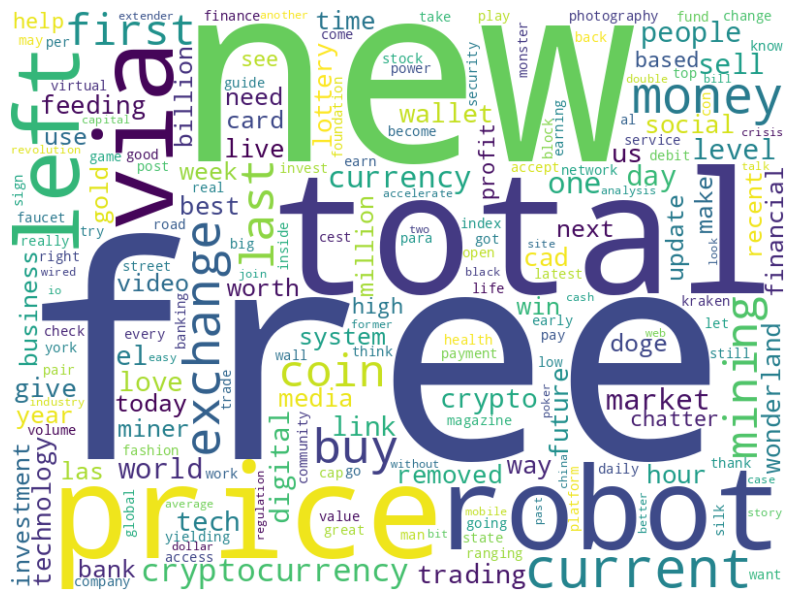

In [8]:
tweets.word_cloud(aggregated_data['text_split'])

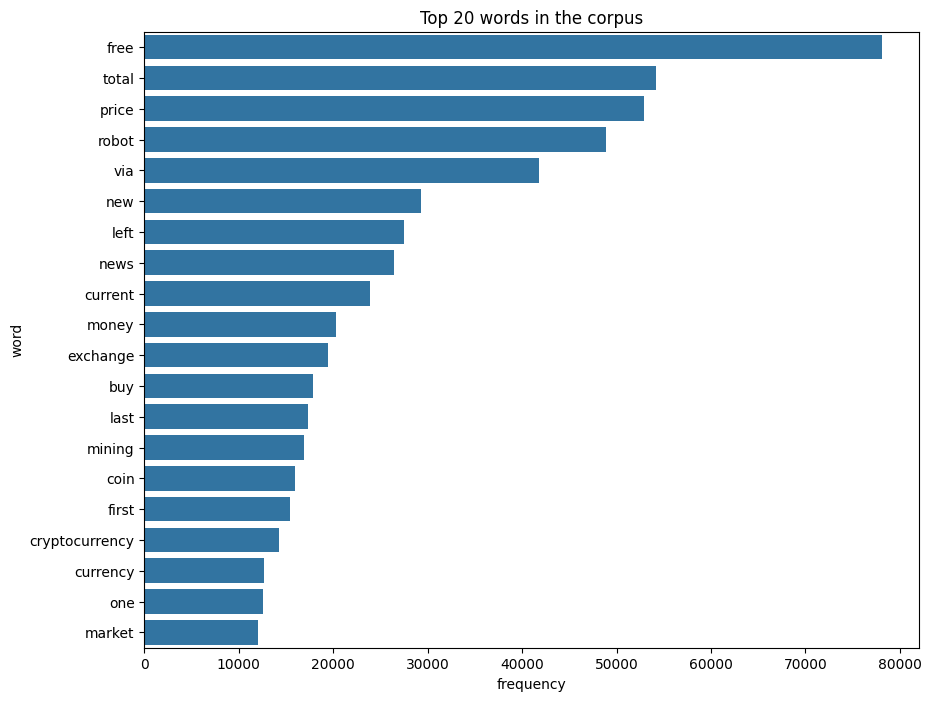

In [9]:
tweets.top_20_words(aggregated_data['text_split'])

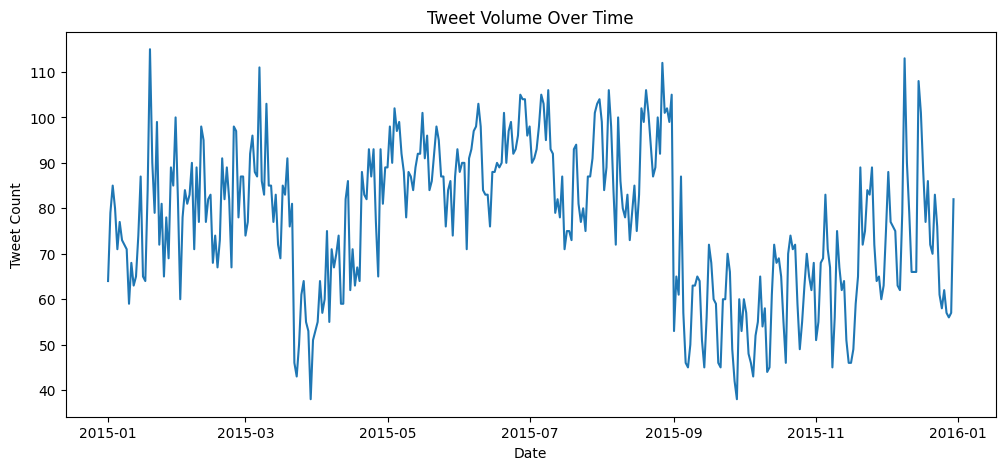

In [13]:
tweets.visualize_by_volume()

In [14]:
data_5day = tweets.get_5day_data(aggregated_data)
data_5day.head()

,Tweets_Day_1,Tweets_Day_2,Tweets_Day_3,Tweets_Day_4,Tweets_Day_5
0,blocked thats achievement still like ser patri...,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...
1,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...
2,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...
3,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...
4,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...,founder twitter working alongside team san pro...


In [15]:
class BTC_data:
  def __init__(self,dataset_path):
    self.btc_data = pd.read_csv(dataset_path)

  def normalize(self,data):
    columns_to_normalize = ['Open','High','Low','Close','Adj Close','Volume']
    scaler = MinMaxScaler()
    data_to_normalize = data.loc[:,columns_to_normalize]
    normalized_data =  scaler.fit_transform(data_to_normalize)
    normalized_data = pd.DataFrame(normalized_data,columns=columns_to_normalize)
    data = pd.concat([data.drop(columns=columns_to_normalize),normalized_data],axis=1)
    return data

In [22]:
btc_data_path = '/content/drive/MyDrive/ResearchPaper/Dataset/BTC_data/BTC-USD_2015.csv'
BTC = BTC_data(btc_data_path)
btc_data =BTC.btc_data

In [23]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [24]:
normalized_data = BTC.normalize(btc_data)
normalized_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,0.497858,0.382988,0.499528,0.474016,0.474016,0.000687
1,2015-01-02,0.475813,0.366796,0.497993,0.476742,0.476742,0.000000
2,2015-01-03,0.478473,0.364368,0.384119,0.358539,0.358539,0.098398
3,2015-01-04,0.361585,0.266000,0.301842,0.299744,0.299744,0.186567
4,2015-01-05,0.305875,0.234682,0.328036,0.335533,0.335533,0.141002


Correlation Coefficient: -0.12564665034547
P-value: 0.016464513386851936


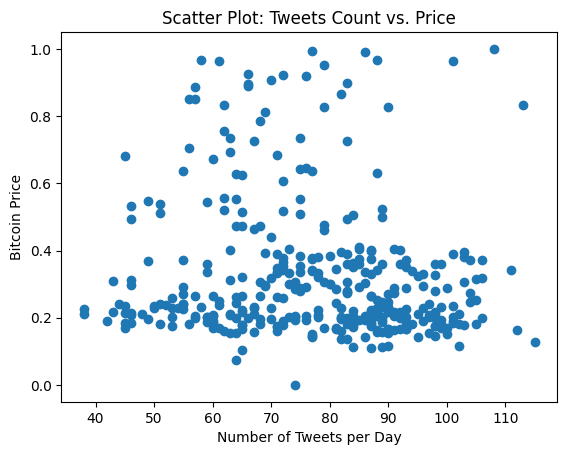

In [25]:
tweets.correlation(tweets.tweets_per_day['Tweets_Count'], normalized_data['Close'][:364])

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # You can adjust max_features as needed
encoded_tweets = vectorizer.fit_transform(aggregated_data['text_split'])

In [ ]:
x = data_5day